In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.preprocessing import StandardScaler # 데이터 scaling
from sklearn.model_selection import train_test_split  # 데이터 분할 : train, test

from sklearn.neighbors import KNeighborsClassifier # 분류 KNN
from sklearn.model_selection import GridSearchCV # 최적모델, 파라미터 검색

from sklearn.metrics import confusion_matrix


## 1) 데이터 구성하기

In [2]:
df_raw = pd.read_csv("HMEQ.csv")
df_raw.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


In [3]:
df_raw.isnull().sum(axis=0)

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

In [4]:
# 결측치 처리
df_raw["JOB"].fillna("Other", inplace=True)
df_raw.fillna(df_raw.mean(), inplace=True)

In [5]:
df_raw.isnull().sum(axis=0)

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

### 더미변수 생성

In [6]:
df_raw_dummy = pd.get_dummies(df_raw)
df_raw_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


In [7]:
df_raw_y = df_raw_dummy["BAD"]
df_raw_x = df_raw_dummy.drop("BAD", axis=1, inplace=False)


In [8]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x,df_raw_y,test_size=0.3, random_state =1234)
print("train data X size: {}".format(df_train_x.shape))

train data X size: (2623, 18)


## 2) 모델 생성

### 기본 옵션으로 모델 생성

In [9]:
# KNN 모델 생성(default 설정)
knn_uncustomized = KNeighborsClassifier()
knn_uncustomized.fit(df_train_x, df_train_y)

# train 데이터 셋 정확도
print("Accuracy on training set: {:.3f}".format(knn_uncustomized.score(df_train_x,df_train_y)))
# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}".format(knn_uncustomized.score(df_test_x,df_test_y)))

Accuracy on training set: 0.916
Accuracy on test set: 0.908


### 이웃 수 중가에 따른 정확도 변화

In [22]:
# train 및 test 정확도 결과 저장용
train_accuracy =[]; test_accuracy=[]
# 최대 이웃 수: 1~15
para_n_neighbors = [i for i in range(1,16)]

for v_n_neighbors in para_n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=v_n_neighbors)
    knn.fit(df_train_x, df_train_y)
    train_accuracy.append(knn.score(df_train_x,df_train_y))
    test_accuracy.append(knn.score(df_test_x,df_test_y))
    
# 데이터 테이블로 저장
df_accuracy_neighbors = pd.DataFrame()
df_accuracy_neighbors["Neighbors"] = para_n_neighbors
df_accuracy_neighbors["TrainAccuracy"] = train_accuracy
df_accuracy_neighbors["TestAccuracy"] = test_accuracy

# 확인
df_accuracy_neighbors.round(3)

,Neighbors,TrainAccuracy,TestAccuracy
0,1,1.000,0.877
1,2,0.928,0.912
2,3,0.929,0.913
3,4,0.916,0.914
4,5,0.916,0.908
5,6,0.913,0.911
6,7,0.913,0.912
7,8,0.910,0.912
8,9,0.911,0.913
9,10,0.909,0.910


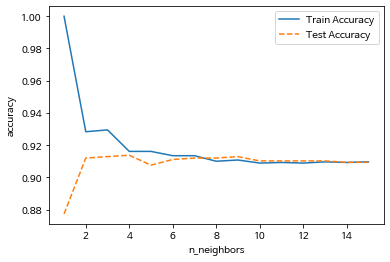

In [18]:
#모델 정확도 그래프 확인
plt.plot(para_n_neighbors, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_n_neighbors, test_accuracy, linestyle="--", label="Test Accuracy")
plt.ylabel("accuracy");
plt.xlabel("n_neighbors");
plt.legend()

In [19]:
# 임의로 지정
n_neighbors = 4

### 가중치 별 이웃 수 중가에 따른 정확도 변화

In [21]:
# train 및 test 정확도 결과 저장용
train_accuracy =[]; test_accuracy=[]
# 이웃 수
para_n_neighbors = [i for i in range(1,11)] * 2
# 가중치(uniform, distance)
para_weights = (["uniform"])*10 + (["distance"]*10)

# zip(list1, list2, ...)를 사용하면 list1과 list2의 인덱스별 값을 하나씩 가져옴
# 1번 loop: n_neighbors = para_n_neihtbor[0], weight = para_weight[0]
# 2번 loop: n_neighbors = para_n_neihtbor[1], weight = para_weight[1]

for (v_n_neighbors, v_weights) in zip(para_n_neighbors, para_weights):
    knn = KNeighborsClassifier(n_neighbors=v_n_neighbors, weights=v_weights)
    knn.fit(df_train_x, df_train_y)
    train_accuracy.append(knn.score(df_train_x,df_train_y))
    test_accuracy.append(knn.score(df_test_x,df_test_y))
    
# 데이터 테이블로 저장
df_accuracy_weights = pd.DataFrame()
df_accuracy_weights["Neighbors"] = para_n_neighbors
df_accuracy_weights["Weights"] = para_weights
df_accuracy_weights["TrainAccuracy"] = train_accuracy
df_accuracy_weights["TestAccuracy"] = test_accuracy

# 확인
df_accuracy_weights.round(3)

,Neighbors,Weights,TrainAccuracy,TestAccuracy
0,1,uniform,1.000,0.877
1,2,uniform,0.928,0.912
2,3,uniform,0.929,0.913
3,4,uniform,0.916,0.914
4,5,uniform,0.916,0.908
5,6,uniform,0.913,0.911
6,7,uniform,0.913,0.912
7,8,uniform,0.910,0.912
8,9,uniform,0.911,0.913
9,10,uniform,0.909,0.910


In [23]:
# 그림을 그리기 위해 데이터의 형태를 변환
df_accuracy_weights_pivots = df_accuracy_weights.pivot(index="Neighbors",
                                                      columns="Weights",
                                                      values=["TrainAccuracy", "TestAccuracy"])
df_accuracy_weights_pivots

TrainAccuracy           TestAccuracy          
Weights        distance   uniform     distance   uniform
Neighbors                                               
1                   1.0  1.000000     0.877333  0.877333
2                   1.0  0.928326     0.877333  0.912000
3                   1.0  0.929470     0.912000  0.912889
4                   1.0  0.916127     0.913778  0.913778
5                   1.0  0.916127     0.912889  0.907556
6                   1.0  0.913458     0.912889  0.911111
7                   1.0  0.913458     0.912889  0.912000
8                   1.0  0.910027     0.913778  0.912000
9                   1.0  0.910789     0.914667  0.912889
10                  1.0  0.908883     0.914667  0.910222

In [24]:
# pivot을 이용할 경우, columns와 values이 2개의 level로 이루어지므로 하나의 level로 변환
level0 = df_accuracy_weights_pivots.columns.get_level_values(0)
level1 = df_accuracy_weights_pivots.columns.get_level_values(1)
df_accuracy_weights_pivots.columns = level0 + "_" + level1
df_accuracy_weights_pivots.head()

,TrainAccuracy_distance,TrainAccuracy_uniform,TestAccuracy_distance,TestAccuracy_uniform
Neighbors,,,,
1,1.0,1.000000,0.877333,0.877333
2,1.0,0.928326,0.877333,0.912000
3,1.0,0.929470,0.912000,0.912889
4,1.0,0.916127,0.913778,0.913778
5,1.0,0.916127,0.912889,0.907556


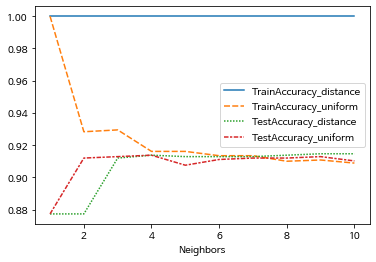

In [28]:
# 그래프 생성. 변수 별 linestyle 구분
sns.lineplot(data=df_accuracy_weights_pivots)

In [29]:
# 임의로 지정
weigths = "uniform"

### 거리계산 방법별 이웃 수 증가에 따른 정확도 변화

In [32]:
# train 및 test 정확도 결과 저장용
train_accuracy =[]; test_accuracy=[]
# 이웃 수
para_n_neighbors = [i for i in range(1,11)] * 3
# 거리계산방법 (minkowski, euclidean, manhattan)
para_metric = (["minkowski"])*10 + (["euclidean"]*10) + (["manhattan"]*10)

for (v_n_neighbors, v_metric) in zip(para_n_neighbors, para_metric):
    knn = KNeighborsClassifier(n_neighbors=v_n_neighbors, metric=v_metric, weights="uniform")
    knn.fit(df_train_x, df_train_y)
    train_accuracy.append(knn.score(df_train_x,df_train_y))
    test_accuracy.append(knn.score(df_test_x,df_test_y))
    
# 데이터 테이블로 저장
df_accuracy_metric = pd.DataFrame()
df_accuracy_metric["Neighbors"] = para_n_neighbors
df_accuracy_metric["Metric"] = para_metric
df_accuracy_metric["TrainAccuracy"] = train_accuracy
df_accuracy_metric["TestAccuracy"] = test_accuracy

# 확인
df_accuracy_metric.round(3)

,Neighbors,Metric,TrainAccuracy,TestAccuracy
0,1,minkowski,1.000,0.877
1,2,minkowski,0.928,0.912
2,3,minkowski,0.929,0.913
3,4,minkowski,0.916,0.914
4,5,minkowski,0.916,0.908
5,6,minkowski,0.913,0.911
6,7,minkowski,0.913,0.912
7,8,minkowski,0.910,0.912
8,9,minkowski,0.911,0.913
9,10,minkowski,0.909,0.910


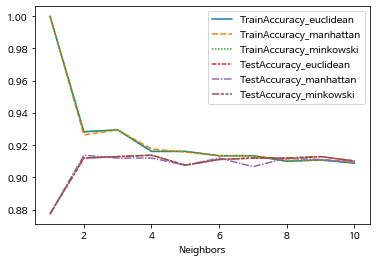

In [34]:
# 정확도를 그래프로 그림
df_accuracy_metric_pivot = df_accuracy_metric.pivot(index="Neighbors",
                                                      columns="Metric",
                                                      values=["TrainAccuracy", "TestAccuracy"])

level0 = df_accuracy_metric_pivot.columns.get_level_values(0)
level1 = df_accuracy_metric_pivot.columns.get_level_values(1)
df_accuracy_metric_pivot.columns = level0 + "_" + level1
sns.lineplot(data = df_accuracy_metric_pivot)

거리 계산 방법별 정확도의 차이가 없음

## 3) 결론도출

In [35]:
# 최종모델
knn_model = KNeighborsClassifier(n_neighbors=4, weights="uniform", metric="euclidean")
knn_model.fit(df_train_x,df_train_y)
# 평가
y_pred = knn_model.predict(df_test_x)

# Train 데이터 셋 정확도
print("Accuracy on training set: {:.3f}".format(knn_model.score(df_train_x, df_train_y)))
# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}".format(knn_model.score(df_test_x, df_test_y)))
#confusion matrix
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuracy on training set: 0.916
Accuracy on test set: 0.914
Confusion matrix: 
[[1018    3]
 [  94   10]]


* 예측 정확도 : 0.914
* 이웃 수 : 4
* 가중치 : 균일 (uniform)
* 거리계산 : 차이없음